# Proyek Klasifikasi Gambar: Dataset Gambar 3 Jenis Hewan (Cat vs Dog vs Panda)
- **Nama:** Abid Juliant Indraswara
- **Email:** abidjuliant@gmail.com
- **ID Dicoding:** abidindraswara

Projek ini akan menghasilkan sebuah model machine learning yang mengklasifikasikan 3 jenis hewan yaitu Cat, Dog dan Panda. Terdiri dengan masing-masing 1000 sampel data gambar atau secara keseluruhan kurang lebih 3000 data gambar. Dataset tersedia di Kaggle secara open-source.

Link Dataset : https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

## Import Library / Packages yang Diperlukan

Beberapa library yang dibutuhkan baik umum untuk pengolahan file sejenisnya, library untuk visualisasi, library untuk memproses data gambar, library untuk modelling machine learning dan library yang sifatnya tambahan sesuai kebutuhan.

### Library Umum

In [38]:
# Import Library Umum
import os, shutil
from shutil import copyfile
import zipfile
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

### Library Visualisasi

In [39]:
# Import Library Visualisasi
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

### Library Pemrosesan Data Gambar

In [40]:
# Import Library Pemrosesan Data Gambar
import cv2
import skimage
from PIL import Image
from skimage import io
from skimage import img_as_ubyte
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

### Library untuk Modelling

In [41]:
# Import Library untuk Modelling
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

### Library Tambahan

In [42]:
# Import Library untuk Mengabaikan Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
# Cek Versi Tensorflow
print(tf.__version__)

2.18.0


## Data Preparation

### Import Dataset Gambar

Menggunakan Google Drive untuk import dataset dari luar Google Colab.

In [44]:
# Mengambil data melalui google drive dengan melakukan autentikasi akun

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Cek Folder
!ls '/content/drive/My Drive/Dataset_MachineLearning/Dataset_Dog_Cat_Panda/'

animals_dog_cat_panda.zip


### Data Loading

In [46]:
# Membuat direktori baru untuk menampung data gambar
!mkdir /content/animals_dcp

mkdir: cannot create directory ‘/content/animals_dcp’: File exists


In [47]:
# Alternatif #1
# Import Dataset Gambar
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Dataset_MachineLearning/Dataset_Dog_Cat_Panda/animals_dog_cat_panda.zip", 'r')
zip_ref.extractall("/content/animals_dcp")
zip_ref.close()

In [48]:
# Alternatif #2
# Unzip file animals.zip
# !mkdir animals_dcp
# !unzip -qq animals_dog_cat_panda.zip -d animals_dcp
# !ls animals_dcp

### Foldering Data Gambar

In [49]:
mypath = 'animals_dcp/animals/animals/'

# List Data Gambar per Label
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

In [50]:
df = pd.DataFrame({
    "path":full_path,
    'file_name':file_name,
    "tag":tag
    })
df.groupby(['tag']).size()

,0
tag,
cats,1000
dogs,1000
panda,1000


In [51]:
# Cek Sampel Data
df.head()

,path,file_name,tag
0,animals_dcp/animals/animals/cats/cats_00600.jpg,cats_00600.jpg,cats
1,animals_dcp/animals/animals/cats/cats_00758.jpg,cats_00758.jpg,cats
2,animals_dcp/animals/animals/cats/cats_00548.jpg,cats_00548.jpg,cats
3,animals_dcp/animals/animals/cats/cats_00400.jpg,cats_00400.jpg,cats
4,animals_dcp/animals/animals/cats/cats_00849.jpg,cats_00849.jpg,cats


In [52]:
# Check value counts
df['tag'].value_counts()

,count
tag,
cats,1000
dogs,1000
panda,1000


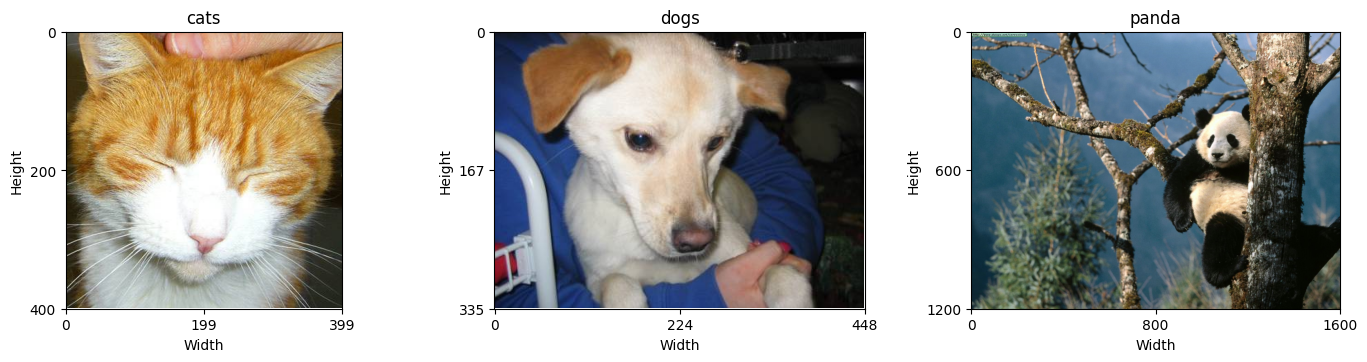

In [53]:
# Mengambil 3 Tag Unik pada Deretan Awal
unique_tags = df['tag'].unique()[:3]

# Membuat Visual
plt.figure(figsize=(14,10))

for id, unique_tag in enumerate(unique_tags):
    plt.subplot(3, 3, id+1)
    img_path = df[df['tag'] == unique_tag].iloc[0, 0]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(unique_tag)

    # Menambahkan skala x dan y berdasarkan ukuran gambar
    height, width = img.shape[:2]
    plt.xticks([0, width//2, width], [0, width//2, width])
    plt.yticks([0, height//2, height], [0, height//2, height])
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.axis('on')

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Train Test Split Dataset

In [54]:
# Data yang dipisahkan dibagi menjadi dua variabel yaitu gambar dan label

X = df['path']
y = df['tag']

In [55]:
# Split dataset menjadi train dan test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 300)

In [57]:
# Memasukkan kembali split data ke dalam tiap dataframe

df_train = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_test = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

In [58]:
# Cek Ukuran dari data latih dan data uji
print('train size', len(df_train))
print('test size', len(df_test))
# print('val size', len(df_validation))

train size 2400
test size 600


In [59]:
# Perbandingan proporsi tiap data gambar yang sudah di split
# Menggabungkan df_train dan df_test dengan pd.concat
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

print('===================================================== \n')
# Menampilkan perbandingan proporsi data berdasarkan 'set' dan 'tag'
print(df_all.groupby(['set','tag']).size(),'\n')
print('===================================================== \n')

# Menampilkan 5 sampel data dari df_all
df_all.sample(5)


set    tag  
test   cats     192
       dogs     204
       panda    204
train  cats     808
       dogs     796
       panda    796
dtype: int64 




,path,tag,set
1211,animals_dcp/animals/animals/panda/panda_00176.jpg,panda,train
639,animals_dcp/animals/animals/cats/cats_00038.jpg,cats,train
1837,animals_dcp/animals/animals/cats/cats_00399.jpg,cats,train
2446,animals_dcp/animals/animals/dogs/dogs_00441.jpg,dogs,test
2581,animals_dcp/animals/animals/panda/panda_00915.jpg,panda,test


In [60]:
# Membuat Variabel Folder Path
datasource_path = "animals/"
dataset_path = "dataset/"

In [61]:
# Menyesuaikan folder ke masing-masing folder
for index, row in tq(df_all.iterrows()):

    # Cek filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])

    # Membuat folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    # Definisi file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)

    # Salin file dari source ke dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

### Image Augmentation

In [62]:
# Menggunakan Image Data Generator untuk Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

In [82]:
# Menerapkan Image Augmentation Konfigurasi
train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


### Cek Visual Sampel Gambar Setelah Preprocessing

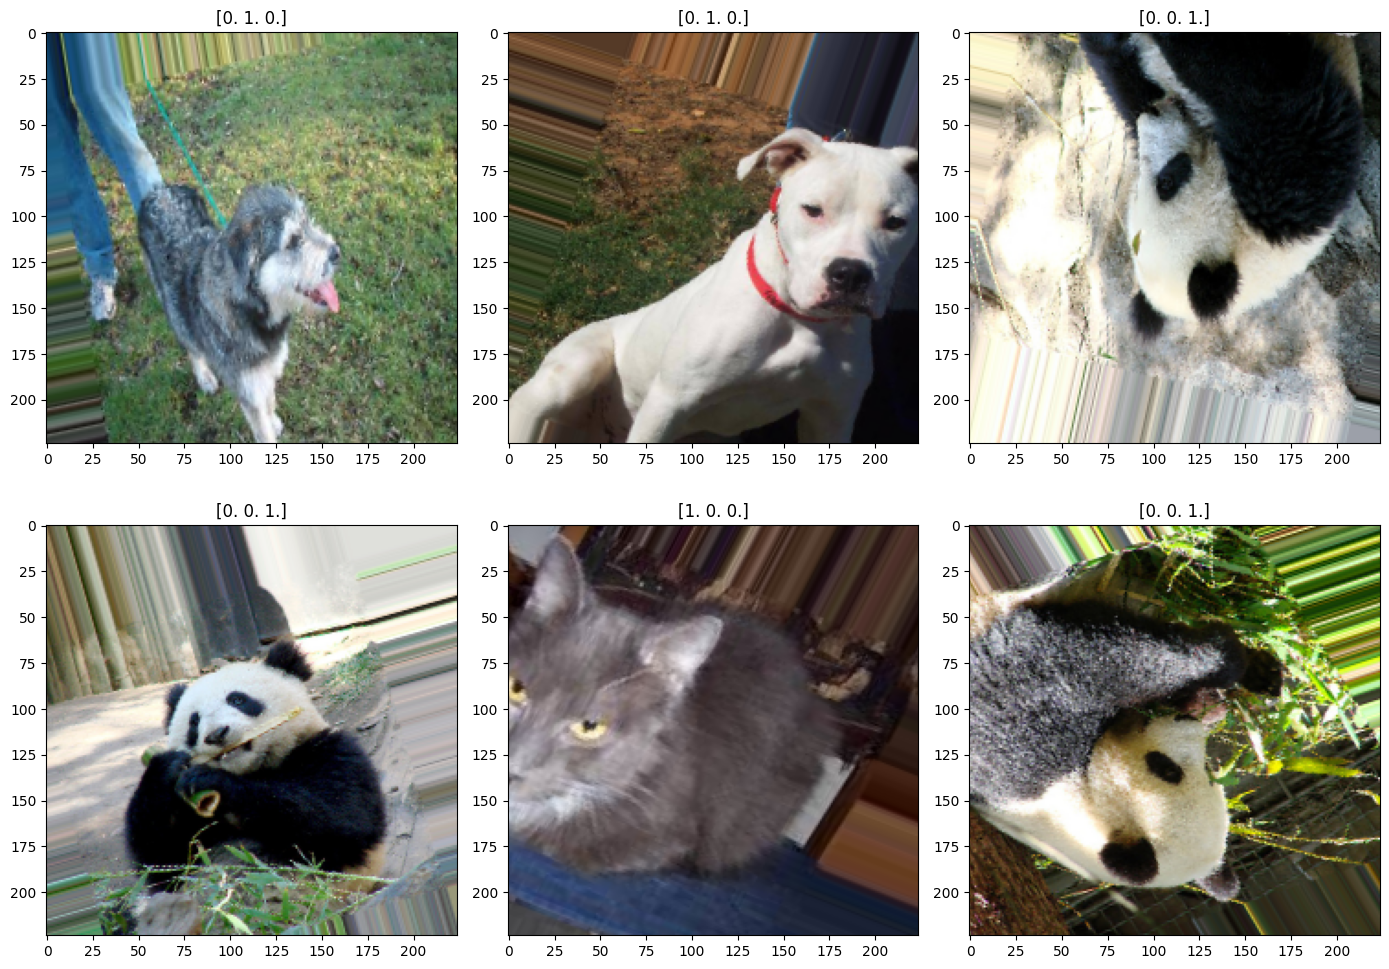

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
ax = ax.flatten()

for i in range(6):
    img, label = next(test_generator)
    ax[i].imshow(img[0])
    ax[i].set_title(str(label[0]))

plt.tight_layout()
plt.show()

### Model Algorithm

In [65]:
# Input layer
inputs = layers.Input(shape=(224, 224, 3))

# Membuat Pre_Trained Model MobileNetV2 without the top layers
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = False  # Freeze pretrained model

# Menerapkan input ke pretrained model
x = pretrained_model(inputs)

# Pooling Layer
x = layers.GlobalAveragePooling2D()(x)

# Dense Layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

# Output Layer
predictions = layers.Dense(3, activation='softmax')(x)

# Mendefinisikan Model
model2 = Model(inputs=inputs, outputs=predictions)

# Menampilkan Summary Model
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,438,851 (9.30 MB)

 Trainable params: 180,867 (706.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [66]:
# Compile the model
print('Model telah dikompilasi')
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model telah dikompilasi


In [67]:
# Callback Function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\nAccuracy above 95%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [83]:
# Menjalankan Model dan Menyimpan History pada Variabel history
history = model2.fit(
    train_generator,
    steps_per_epoch = 25,
    epochs = 100,
    validation_data = test_generator,
    validation_steps = 5,
    verbose = 2,
    callbacks = [callbacks]
)

Epoch 1/100
25/25 - 56s - 2s/step - accuracy: 0.9613 - loss: 0.1055 - val_accuracy: 0.9375 - val_loss: 0.2107
Epoch 2/100
25/25 - 54s - 2s/step - accuracy: 0.9650 - loss: 0.0903 - val_accuracy: 0.9187 - val_loss: 0.2108
Epoch 3/100
25/25 - 53s - 2s/step - accuracy: 0.9663 - loss: 0.0782 - val_accuracy: 0.9250 - val_loss: 0.2198
Epoch 4/100
25/25 - 6s - 221ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9417 - val_loss: 0.1576
Epoch 5/100
25/25 - 52s - 2s/step - accuracy: 0.9638 - loss: 0.1004 - val_accuracy: 0.9312 - val_loss: 0.1613
Epoch 6/100
25/25 - 52s - 2s/step - accuracy: 0.9563 - loss: 0.1107 - val_accuracy: 0.9438 - val_loss: 0.1564
Epoch 7/100

Accuracy above 95%, finish training!
25/25 - 60s - 2s/step - accuracy: 0.9650 - loss: 0.0788 - val_accuracy: 0.9625 - val_loss: 0.0864


## Evaluasi dan Visualisasi

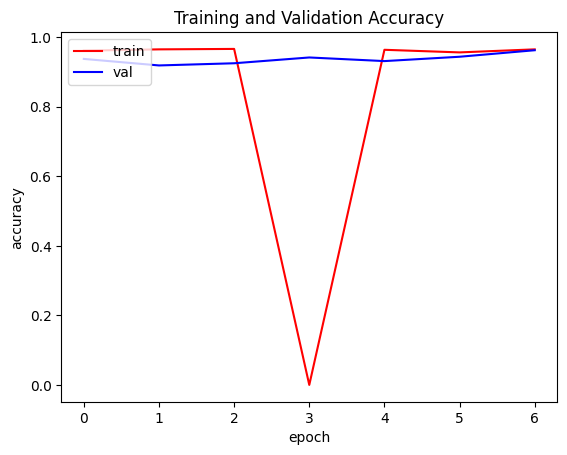

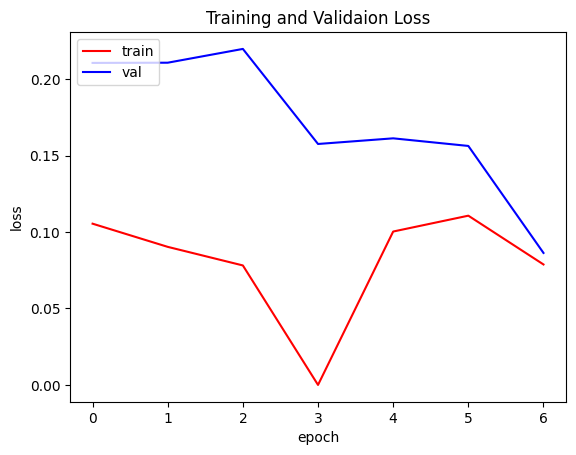

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## Konversi Model

### Default Saved Model

In [71]:

tf.saved_model.save(model2, 'saved_model')

### TFJS

In [72]:
!pip install tensorflowjs

In [73]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model2, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


### TFLite

In [86]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

os.makedirs('tf_lite_model', exist_ok=True)
folder_path = 'tf_lite_model'
file_path = f'{folder_path}/model2.tflite'

with open(file_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt9jnb0ye'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137999667071808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999727449840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626408656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626413760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626414112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626409360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626312640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626315280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626311232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137999626313168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1379996263

In [87]:
def recreate_labels():
    labels = [folder for folder in os.listdir('/content/animals_dcp/animals/animals') if not folder.startswith('.')]
    with open('tf_lite_model/labels.txt', 'w') as file:
        for label in labels:
            file.write(label)
            file.write('\n')
recreate_labels()

In [89]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.5
astropy-iers-data==0.2024.11.4.0.33.34
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.25.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.1
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1